In [2]:
from cobra.io import load_json_model
import pandas as pd
import numpy as np
from cameo.models import universal

# Load and Constrain the model

In [3]:
model = load_json_model("/Users/clie/Desktop/Side_Projects/Ustilago_maydis_Thiemo_Zambanini/memote-umay/iCL1079.json")

In [4]:
model.objective = model.reactions.BIOMASS_REACTION
model.reactions.EX_glc__D_e.bounds = -10, 0
model.reactions.EX_pnto_R_e.bounds = 0, 1000
model.reactions.EX_pydx_e.bounds = 0, 1000
model.reactions.EX_4abz_e.bounds = 0, 1000
model.reactions.EX_btn_e.bounds = 0, 1000
model.reactions.EX_thm_e.bounds = 0, 1000
print model.slim_optimize()

0.493984381696


# Load the Growth Data

In [5]:
growth_data = pd.read_csv('/Users/clie/Desktop/Side_Projects/Ustilago_maydis_Thiemo_Zambanini/memote-umay/growth_study.csv')

# Load the MNX Reference Database

In [6]:
chem_xref = pd.read_table('/Users/clie/Dev/cameo/data/metanetx/chem_xref.tsv.gz', compression='gzip')

In [7]:
uni = universal.metanetx_universal_model_bigg

In [8]:
def test_in_universal(biolog_name, model):
#     biolog_name = growth_data["Biolog_Name"][24].lower().split()
#     regex_group = ''.join(["(?=.*"+'{}'.format(x)+")" for x in biolog_name])
#     result = model.metabolites.query(regex_group, attribute="name")
    result = chem_xref[chem_xref['Description'].str.contains(biolog_name, case=False) == True]['MNX_ID'].to_dict()
    if result:
        return result
    else:
        return "Not in universal"

In [9]:
def test_in_model(met_id, model):
    result = model.metabolites.query('^' + str(met_id) + '_.*', attribute="id")
    if result:
        external_mets = [met.id for met in result if met.id.endswith('_e')]
        internal_mets = [met.id for met in result if met.id.endswith('_c')]
    else:
        return "Not in model"
    
    if external_mets:
        return external_mets
    elif internal_mets:
        return internal_mets

## Test which IDs exist in the model, and which exist in the reference database

In [10]:
status = []
temp_storage = []
for i, biolog_name in enumerate(growth_data["Biolog_Name"]):
    if type(growth_data["BiGG_ID"][i]) != float:
        status.append(test_in_model(growth_data["BiGG_ID"][i], model))
    else:
        status.append(test_in_universal(growth_data["Biolog_Name"][i], uni))

# Test each metabolite that exists in the model for growth without and with an added exchange/ demand reaction.

In [11]:
def find_exchange_in_model(met_id):
    result = model.metabolites.get_by_id(met_id).reactions & set(model.exchanges)
    if len(result) >= 1:
        return list(result)[0]
    else:
        return False

In [12]:
exchange_present = []
in_silico_growth = []
growth_rates = []
for i, entry in enumerate(status):
    if type(entry) == list:
        inner_list_ex = []
        inner_list_growth = []
        inner_list_rates = []
        for met_id in entry:
            with model:
                model.reactions.EX_glc__D_e.bounds = 0, 0
                exchange_rxn = find_exchange_in_model(met_id)
                if exchange_rxn:
                    exchange_rxn.bounds = -10, 0
                    inner_list_ex.append(True)
                else:
                    model.add_boundary(metabolite=model.metabolites.get_by_id(met_id), type='demand', lb=-10, ub=0)
                    inner_list_ex.append(False)
                solution = model.slim_optimize()
                if solution > 0:
                    inner_list_growth.append(True)
                    inner_list_rates.append(solution)
                else:
                    inner_list_growth.append(False)
                    inner_list_rates.append(0)
        if any(inner_list_growth):
            in_silico_growth.append(True)
        else:
            in_silico_growth.append(False)
            
        if any(inner_list_ex):
            exchange_present.append(True)
        else:
            exchange_present.append(False)
        
        if any(inner_list_rates):
            growth_rates.append(sum(inner_list_rates))
        else:
            growth_rates.append(0)
        
    else:
        exchange_present.append(False)
        in_silico_growth.append(False)
        growth_rates.append(0)

# Report boolean growth result, growth rate, and if a boundary was present.

In [13]:
growth_data['In_Silico_Growth_Rate'] = pd.Series(data=growth_rates, index=growth_data.index)

In [14]:
growth_data['Growth_Prediction'] = pd.Series(data=in_silico_growth, index=growth_data.index)

In [15]:
growth_data['Boundary_Present'] = pd.Series(data=exchange_present, index=growth_data.index)

In [16]:
lables = []
for item in status:
    if type(item) == list:
        lables.append("In model")
    elif type(item) == str:
        lables.append(item)
    elif type(item) == dict:
        lables.append("In MNX")

In [17]:
growth_data['Status'] = pd.Series(data=lables, index=growth_data.index)

# Combine results into original table

In [18]:
growth_data

,Biolog_Name,BiGG_ID,growth_experiment,In_Silico_Growth_Rate,Growth_Prediction,Boundary_Present,Status
0,2-Aminoethanol,etha,1,0.000000,False,False,In model
1,2-Hydroxy Benzoic Acid,salc,1,0.000000,False,True,In model
2,4-Hydroxy Benzoic Acid,4hbz,1,0.000000,False,False,In model
3,5-Keto-D-Gluconic Acid,5dglcn,1,0.304250,True,True,In model
4,Acetic Acid,ac,1,0.000000,False,True,In model
5,_-D-Glucose,glc_A,1,0.000000,False,False,Not in model
6,_-Hydroxy Butyric Acid,2hb,1,0.000000,False,False,Not in model
7,_-Keto Valeric Acid,2-ketovalerate,1,0.000000,False,False,Not in model
8,_-Keto-Butyric Acid,2obut,1,0.000000,False,True,In model
9,_-Keto-Glutaric Acid,agk,1,0.000000,False,False,Not in model


# Build Confusion Matrix

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
y_true = list(growth_data['growth_experiment'])
y_pred = list(growth_data['Growth_Prediction'])

In [21]:
C = confusion_matrix(y_true, y_pred)

In [22]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

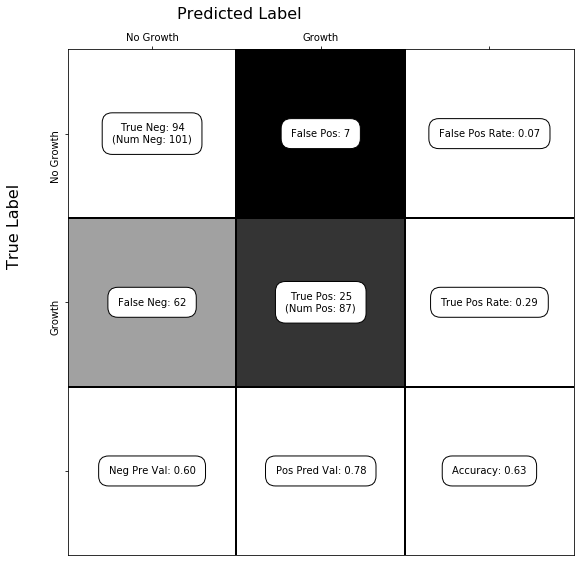

In [23]:
show_confusion_matrix(C, class_labels=['No Growth','Growth'])

# Arrange table so that hits are well aligned

Such that first all the true positives are shown, then all the true negatives, then false positives, then false negatives.

In [37]:
confusion_marker = []
for i, item in enumerate(growth_data['growth_experiment']):
    if item == True and growth_data['Growth_Prediction'][i] == True:
        confusion_marker.append(1)
    elif item == False and growth_data['Growth_Prediction'][i] == False:
        confusion_marker.append(2)
    elif item == False and growth_data['Growth_Prediction'][i] == True:
        confusion_marker.append(3)
    elif item == True and growth_data['Growth_Prediction'][i] == False:
        confusion_marker.append(4)

In [38]:
growth_data['Confusion_Marker'] = pd.Series(data=confusion_marker, index=growth_data.index)

In [46]:
growth_data

,Biolog_Name,BiGG_ID,growth_experiment,In_Silico_Growth_Rate,Growth_Prediction,Boundary_Present,Status,Confusion_Marker
0,2-Aminoethanol,etha,1,0.000000,False,False,In model,4
1,2-Hydroxy Benzoic Acid,salc,1,0.000000,False,True,In model,4
2,4-Hydroxy Benzoic Acid,4hbz,1,0.000000,False,False,In model,4
3,5-Keto-D-Gluconic Acid,5dglcn,1,0.304250,True,True,In model,1
4,Acetic Acid,ac,1,0.000000,False,True,In model,4
5,_-D-Glucose,glc_A,1,0.000000,False,False,Not in model,4
6,_-Hydroxy Butyric Acid,2hb,1,0.000000,False,False,Not in model,4
7,_-Keto Valeric Acid,2-ketovalerate,1,0.000000,False,False,Not in model,4
8,_-Keto-Butyric Acid,2obut,1,0.000000,False,True,In model,4
9,_-Keto-Glutaric Acid,agk,1,0.000000,False,False,Not in model,4


In [47]:
sorted_gd = growth_data.sort_values(['Confusion_Marker'])

In [48]:
sorted_gd

,Biolog_Name,BiGG_ID,growth_experiment,In_Silico_Growth_Rate,Growth_Prediction,Boundary_Present,Status,Confusion_Marker
29,D-Ribose,rib__D,1,0.250015,True,True,In model,1
76,Pyruvic Acid,pyr,1,0.086929,True,True,In model,1
32,D-Xylose,xyl__D,1,0.433506,True,True,In model,1
31,D-Trehalose,tre,1,0.987969,True,True,In model,1
61,L-Phenylalanine,phe__L,1,0.436362,True,True,In model,1
28,D-Raffinose,raffin,1,1.481953,True,True,In model,1
41,L-Alanine,ala__L,1,0.123496,True,True,In model,1
84,Sucrose,sucr,1,0.987969,True,True,In model,1
25,D-Mannitol,mnl,1,0.493984,True,True,In model,1
23,Dihydroxy Acetone,dha,1,0.246992,True,True,In model,1


In [49]:
sorted_gd.to_excel("/Users/clie/Desktop/Side_Projects/Ustilago_maydis_Thiemo_Zambanini/memote-umay/sorted_growth_study.xlsx")